# **Cards Image Dataset**
In our project, we will work with the Cards Image dataset: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

It contains RGB images of poker cards labeled with a string depending on the value and the suit.

The train, val and test datasets are provided in zip format, so the first step will be to decompress it into the Google Colab Disk.

In [1]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import random

# Mount Google Drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/DeepLearning_2023/Final/poker-database.zip'
data_path = '/content/poker/'
results_path = '/content/drive/MyDrive/DeepLearning_2023/Final/Results'


Mounted at /content/drive


In [2]:
# unzip database (no need to run if already in disk)
import zipfile
import os

if not os.path.exists(data_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

# Dataset and Dataloader


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as tf
from PIL import Image
import os

# Define labels_to_number and number_to_labels dictionaries
labels_to_number = {}
number_to_labels = {}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_path = []
        self.labels = []

        # Get the classes of the dataset
        classes = os.listdir(root_dir)
        classes.sort()

        for label_idx, class_name in enumerate(classes):

            # Create the dictionaries
            labels_to_number[class_name] = label_idx
            number_to_labels[label_idx] = class_name

            # Get the image paths of the current class
            class_dir = os.path.join(root_dir, class_name)
            image_files = os.listdir(class_dir)

            for image_file in image_files:
                # Open the image
                image_path = os.path.join(class_dir, image_file)

                if(not os.path.isdir(image_path)):
                    self.images_path.append(image_path)

                    self.labels.append(labels_to_number[class_name])

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        image = Image.open(image_path)

        # Apply the preprocessing
        image = self.transform(image)

        label = self.labels[idx]
        return image, label


# Compose the transformations
tr = tf.Compose([
    tf.Resize((224, 224)),
    tf.ToTensor()
   # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 256
#batch_size = 50

# Define the train loader
train_dataset = Dataset(data_path + "/train", tr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the validation loader
val_dataset = Dataset(data_path + "/valid", tr)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Load the test dataset
test_dataset = Dataset(data_path + '/test', tr)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Number of Classes
class_count = len(labels_to_number)
print(f"classes: {class_count}")
print(f"images: {len(train_dataset)}")

classes: 53
images: 7624


# Load and visualize a card to check that everything is ok

Label: two of hearts


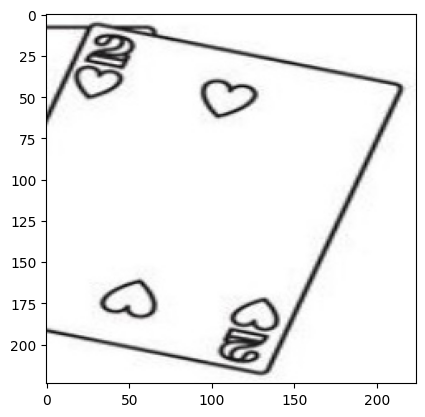

In [4]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

example_image, example_label = images[0].permute(1, 2, 0), labels[0]

print('Label: ' + str(number_to_labels[example_label.item()]))
plt.imshow(example_image)

# Load the model you want to visualize
In our case we will visualize our modifiend efficentnet that we trained in the models file

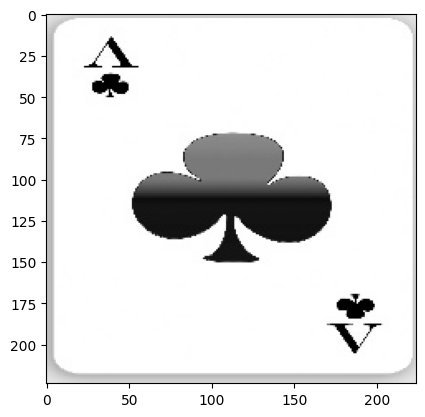

ace of clubs


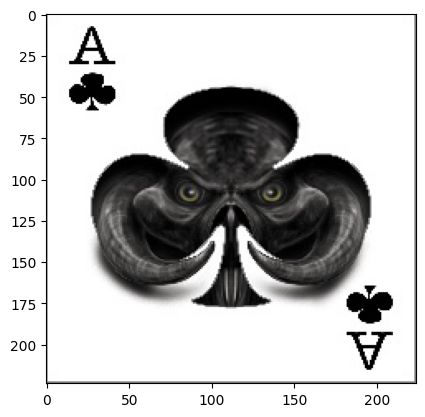

ace of clubs


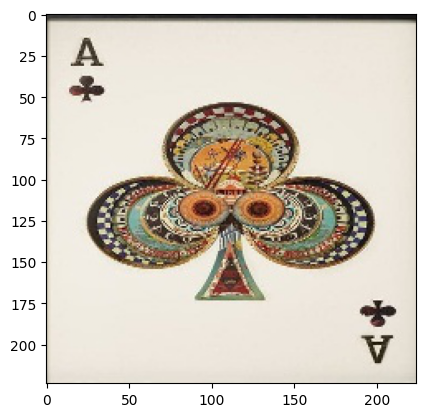

ace of clubs


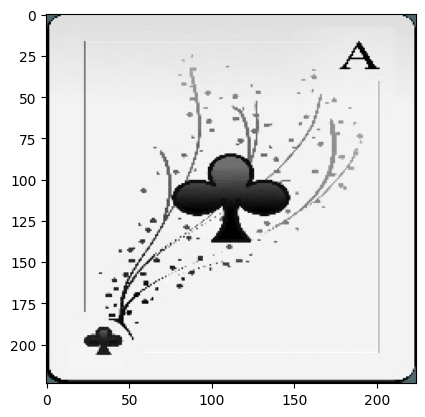

ace of clubs


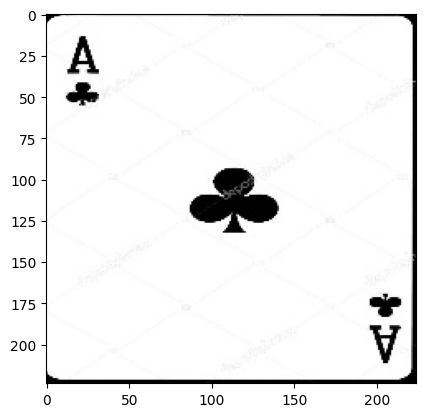

ace of clubs


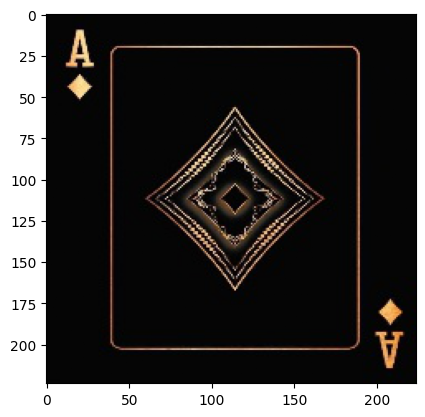

ace of diamonds


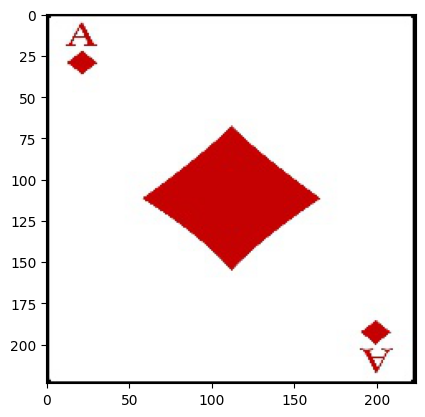

ace of diamonds


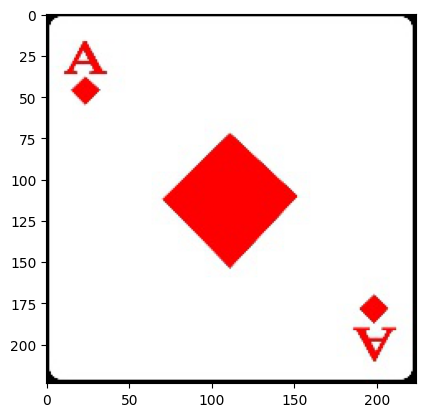

ace of diamonds


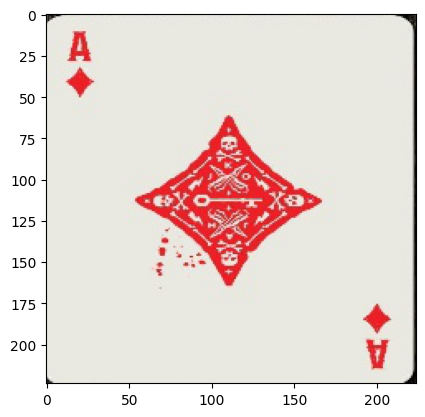

ace of diamonds


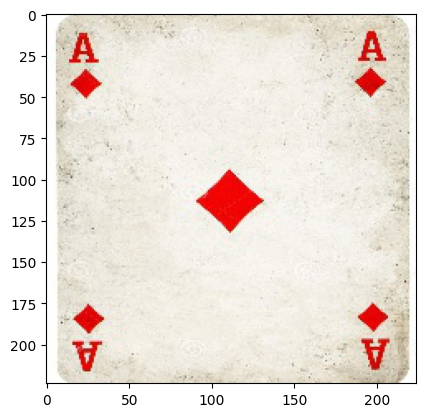

ace of diamonds


In [10]:
from torchvision.models import efficientnet_b3
#MyModelv2 accuracy
model = efficientnet_b3()

num_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    #nn.BatchNorm1d(num_features, eps=0.001, momentum=0.99),
    nn.BatchNorm1d(num_features),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, class_count),
    nn.Softmax(dim=1)
)

model.load_state_dict(torch.load(results_path + '/eficientnet-augmented-database-epoch10-93acc.ckpt', map_location=torch.device('cpu')))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# try some real images we took
model.eval()
image_path = '/content/poker/test'
#image_path = "/content/drive/Shareddrives/Deep Learning/Final/Data/real test"
model.to(device)

# Try with cropping
tr = tf.Compose([
    tf.Resize((224, 224)),
    tf.ToTensor()
   # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
)

real_dataset = Dataset(image_path, tr)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=10, shuffle=False)

images, labels = next(iter(real_loader))
images = images.to(device)
# print(images.shape)
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

for i, image in enumerate(images):
  image = image.cpu()
  plt.imshow(image.permute(1, 2, 0))
  plt.show()
  print(number_to_labels[predicted[i].item()])


# Compute and show the CAM

0.996 -> ace of clubs
0.003 -> ace of spades
0.000 -> four of clubs
0.000 -> ace of hearts
0.000 -> king of clubs
Output CAM.jpg for the top1 prediction: ace of clubs


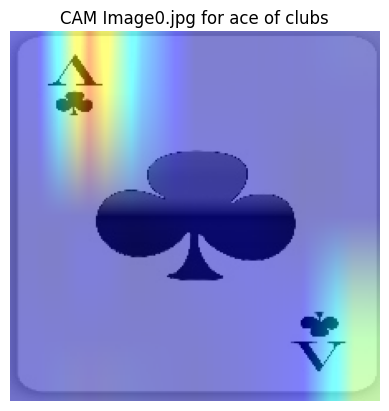

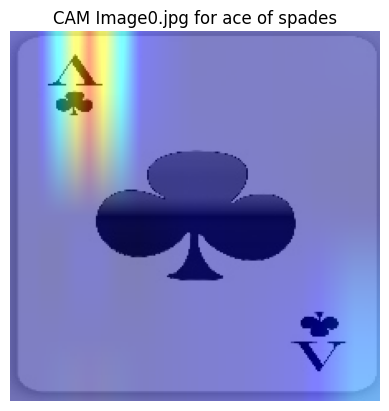

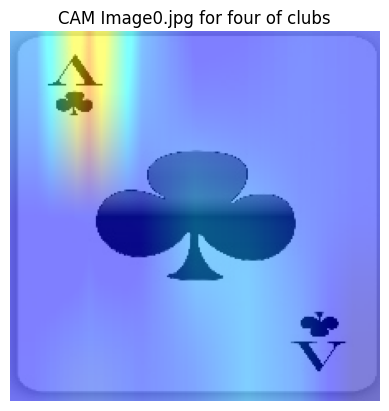

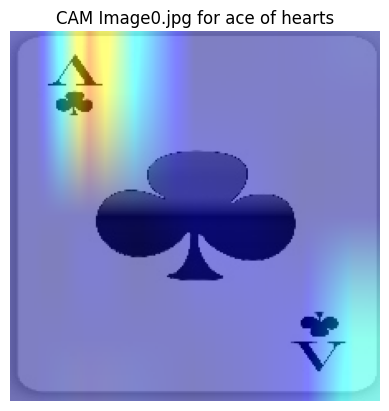

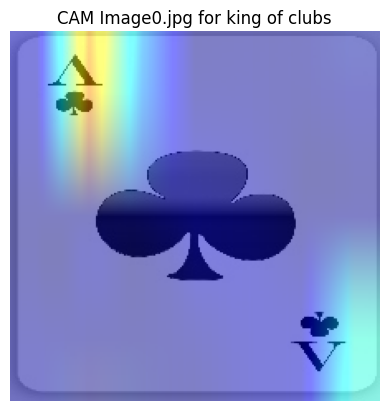

In [11]:
from google.colab.patches import cv2_imshow
import torch.nn.functional as F
import cv2
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape

    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())


def show_cam(CAMs, width, height, orig_image, class_idx, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.resize(cam, (width, height))

        # Apply colormap 'jet' using OpenCV
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Convert the heatmap to PIL Image format
        heatmap_pil = Image.fromarray(heatmap)

        # Convert the original image to PIL Image format
        transform = tf.ToPILImage()
        orig_image_pil = transform(orig_image.squeeze())

        # Resize the heatmap to match the size of the original image
        heatmap_resized = heatmap_pil.resize((orig_image_pil.width, orig_image_pil.height), Image.ANTIALIAS)

        # Blend the heatmap with the original image using alpha blending
        blended_image = Image.blend(orig_image_pil, heatmap_resized, alpha=0.5)

        # Convert the blended image back to numpy array
        blended_image_np = np.array(blended_image)

        # Create figure and axes
        fig, ax = plt.subplots()

        # Display the blended image
        ax.imshow(blended_image_np)
        ax.axis('off')
        ax.set_title(f'CAM {save_name} for {class_idx[i]}')

        # Show the plot
        plt.show()

        # Save the image
        fig.savefig(f"{results_path}/CAM_{save_name}.jpg")
        plt.close(fig)


model.eval()

features_blobs = []

model._modules.get("features").register_forward_hook(hook_feature)


# Get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-4].data.cpu().numpy())

# Load a test image
images, labels = next(iter(real_loader))
images = images.to(device)
# print(images.shape)
outputs = model(images)
for img_idx in range(len(features_blobs)):
    labeled_outputs = [(label, prob) for label, prob in enumerate(outputs.detach().cpu().numpy()[img_idx])]
    labeled_outputs.sort(key=lambda a: a[1], reverse=True)

    # Output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(labeled_outputs[i][1], number_to_labels[labeled_outputs[i][0]]))

    # Generate class activation mapping for the top1 prediction
    CAMs = returnCAM(features_blobs[img_idx][0], weight_softmax, [labeled_outputs[i][0] for i in range(5)])

    # Render the CAM and output
    print('Output CAM.jpg for the top1 prediction: %s' % number_to_labels[labeled_outputs[0][0]])
    height, width, _ = images[img_idx].shape

    show_cam(CAMs, width, height, images[img_idx], [number_to_labels[labeled_outputs[i][0]] for i in range(5)], f"Image{img_idx}.jpg")